In [1]:
# Hyperparameters
N_EPOCH=200
BATCH_SIZE=64
LR=0.0002
B1=0.5
B2=0.999
N_CPU=8
LATENT_DIM=100
IMG_SIZE=32
CHANNELS=1
N_CRITIC=5
CLIP_VALUE=0.01
SAMPLE_INTERVAL=400
DATA_DIR = "/home/giusy/datasets"

In [2]:
import os
import numpy as np
import math
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import make_grid
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch
from tqdm import tqdm

from matplotlib import pyplot as plt
import sys

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(os.path.join(DATA_DIR,"images_wgan_gp_modified"), exist_ok=True)

class Parser:
    n_epochs= N_EPOCH
    batch_size= BATCH_SIZE
    lr= LR
    b1= B1
    b2= B2
    n_cpu= N_CPU
    latent_dim= LATENT_DIM
    img_size= IMG_SIZE
    channels= CHANNELS
    n_critic= N_CRITIC
    clip_value= CLIP_VALUE
    sample_interval= SAMPLE_INTERVAL
    data_dir = DATA_DIR

opt = Parser()

%matplotlib inline

In [3]:
img_shape = (opt.channels, opt.img_size, opt.img_size)

In [4]:
cuda = True if torch.cuda.is_available() else False

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Linear(128 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [6]:
# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs(opt.data_dir, exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(root=opt.data_dir,train=True,download=False,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    num_workers=opt.n_cpu,
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [7]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: DL=-1.6373, GL=-0.7338


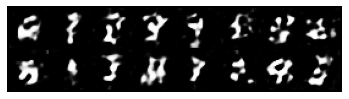

  0%|          | 1/200 [01:13<4:03:20, 73.37s/it]

Epoch 2: DL=-0.9844, GL=-0.3450


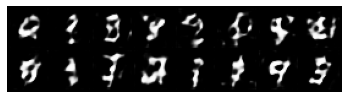

  1%|          | 2/200 [02:26<4:01:45, 73.26s/it]

Epoch 3: DL=-1.0859, GL=-0.1857


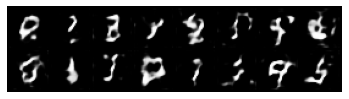

  2%|▏         | 3/200 [03:48<4:13:13, 77.13s/it]

Epoch 4: DL=-1.0062, GL=-0.1346


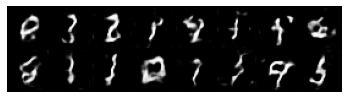

  2%|▏         | 4/200 [05:33<4:47:34, 88.03s/it]

Epoch 5: DL=-0.9010, GL=-0.0983


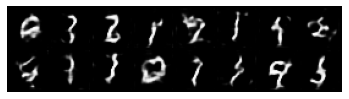

  2%|▎         | 5/200 [07:17<5:05:29, 94.00s/it]

Epoch 6: DL=-0.8818, GL=-0.1054


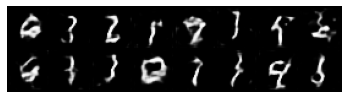

  3%|▎         | 6/200 [09:02<5:15:26, 97.56s/it]

Epoch 7: DL=-0.8338, GL=-0.1338


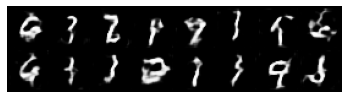

  4%|▎         | 7/200 [10:46<5:21:01, 99.80s/it]

Epoch 8: DL=-0.8050, GL=-0.1405


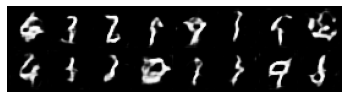

  4%|▍         | 8/200 [12:31<5:24:33, 101.42s/it]

Epoch 9: DL=-0.7807, GL=-0.1830


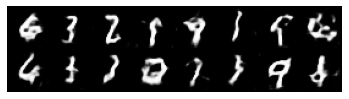

  4%|▍         | 9/200 [14:15<5:25:47, 102.34s/it]

Epoch 10: DL=-0.8049, GL=-0.1604


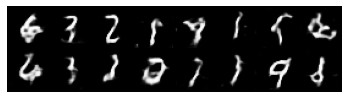

  5%|▌         | 10/200 [16:00<5:26:22, 103.07s/it]

Epoch 11: DL=-0.7642, GL=-0.2219


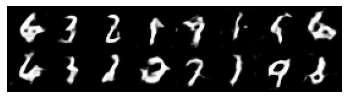

  6%|▌         | 11/200 [17:45<5:26:08, 103.54s/it]

Epoch 12: DL=-0.8002, GL=-0.2630


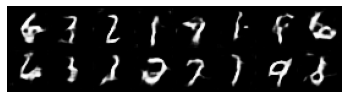

  6%|▌         | 12/200 [19:29<5:25:42, 103.95s/it]

Epoch 13: DL=-0.7884, GL=-0.3246


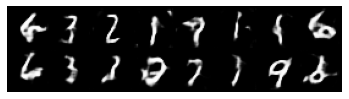

  6%|▋         | 13/200 [21:14<5:24:31, 104.12s/it]

Epoch 14: DL=-0.7972, GL=-0.3254


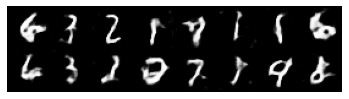

  7%|▋         | 14/200 [22:59<5:23:24, 104.33s/it]

Epoch 15: DL=-0.7781, GL=-0.4097


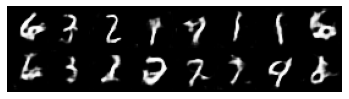

  8%|▊         | 15/200 [24:43<5:21:55, 104.41s/it]

Epoch 16: DL=-0.7639, GL=-0.3831


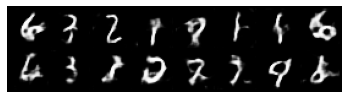

  8%|▊         | 16/200 [26:28<5:20:26, 104.49s/it]

Epoch 17: DL=-0.7844, GL=-0.5298


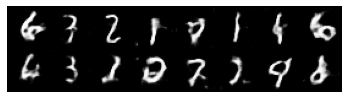

  8%|▊         | 17/200 [28:12<5:18:33, 104.44s/it]

Epoch 18: DL=-0.8247, GL=-0.5772


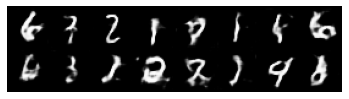

  9%|▉         | 18/200 [29:57<5:16:59, 104.50s/it]

Epoch 19: DL=-0.7783, GL=-0.5283


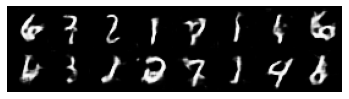

 10%|▉         | 19/200 [31:42<5:15:17, 104.52s/it]

Epoch 20: DL=-0.7935, GL=-0.7005


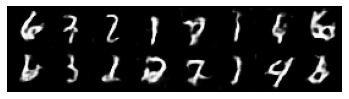

 10%|█         | 20/200 [33:26<5:13:39, 104.55s/it]

Epoch 21: DL=-0.7815, GL=-0.7397


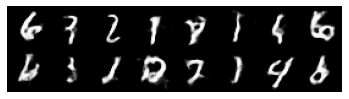

 10%|█         | 21/200 [35:11<5:11:56, 104.56s/it]

Epoch 22: DL=-0.8096, GL=-0.7438


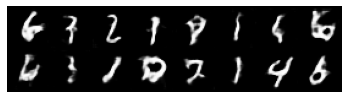

 11%|█         | 22/200 [36:55<5:10:12, 104.56s/it]

Epoch 23: DL=-0.8208, GL=-0.7957


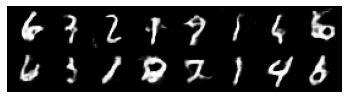

 12%|█▏        | 23/200 [38:40<5:08:29, 104.57s/it]

Epoch 24: DL=-0.8151, GL=-0.8293


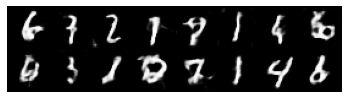

 12%|█▏        | 24/200 [40:24<5:06:41, 104.56s/it]

Epoch 25: DL=-0.7977, GL=-0.8949


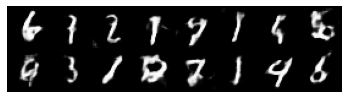

 12%|█▎        | 25/200 [42:09<5:05:01, 104.58s/it]

Epoch 26: DL=-0.8218, GL=-0.9542


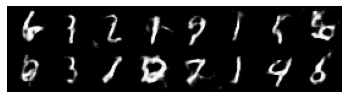

 13%|█▎        | 26/200 [43:53<5:03:05, 104.51s/it]

Epoch 27: DL=-0.8173, GL=-0.9758


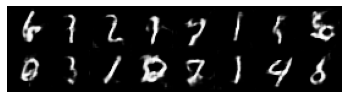

 14%|█▎        | 27/200 [45:38<5:01:43, 104.65s/it]

Epoch 28: DL=-0.7928, GL=-0.8738


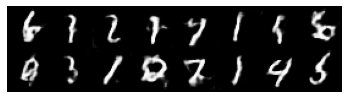

 14%|█▍        | 28/200 [47:23<4:59:50, 104.60s/it]

Epoch 29: DL=-0.7881, GL=-0.9207


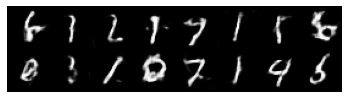

 14%|█▍        | 29/200 [49:08<4:58:13, 104.64s/it]

Epoch 30: DL=-0.8134, GL=-0.9628


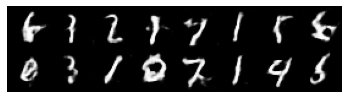

 15%|█▌        | 30/200 [50:52<4:56:26, 104.62s/it]

Epoch 31: DL=-0.8103, GL=-1.0441


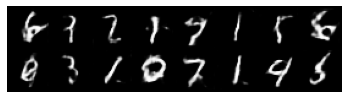

 16%|█▌        | 31/200 [52:37<4:54:50, 104.68s/it]

Epoch 32: DL=-0.7582, GL=-1.0096


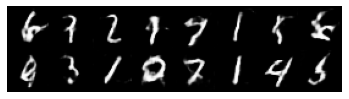

 16%|█▌        | 32/200 [54:21<4:52:45, 104.56s/it]

Epoch 33: DL=-0.7536, GL=-1.0287


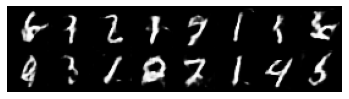

 16%|█▋        | 33/200 [56:06<4:51:05, 104.58s/it]

Epoch 34: DL=-0.7122, GL=-1.0037


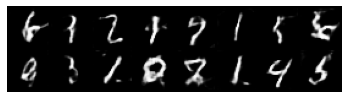

 17%|█▋        | 34/200 [57:50<4:49:02, 104.47s/it]

Epoch 35: DL=-0.7513, GL=-1.1146


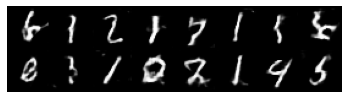

 18%|█▊        | 35/200 [59:35<4:47:32, 104.56s/it]

Epoch 36: DL=-0.7578, GL=-1.0946


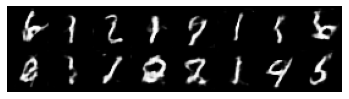

 18%|█▊        | 36/200 [1:01:19<4:45:40, 104.52s/it]

Epoch 37: DL=-0.7272, GL=-1.1321


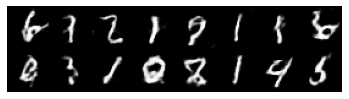

 18%|█▊        | 37/200 [1:03:04<4:44:00, 104.54s/it]

Epoch 38: DL=-0.6954, GL=-1.1832


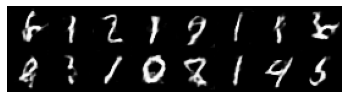

 19%|█▉        | 38/200 [1:04:48<4:42:14, 104.53s/it]

Epoch 39: DL=-0.7317, GL=-1.1653


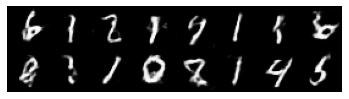

 20%|█▉        | 39/200 [1:06:33<4:40:41, 104.61s/it]

Epoch 40: DL=-0.7055, GL=-1.1888


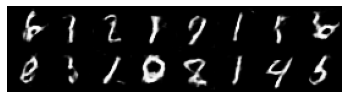

 20%|██        | 40/200 [1:08:18<4:38:47, 104.55s/it]

Epoch 41: DL=-0.7234, GL=-1.1237


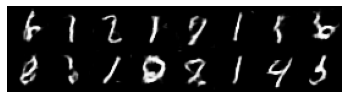

 20%|██        | 41/200 [1:10:02<4:37:09, 104.59s/it]

Epoch 42: DL=-0.6665, GL=-1.1462


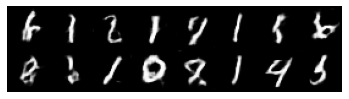

 21%|██        | 42/200 [1:11:47<4:35:13, 104.51s/it]

Epoch 43: DL=-0.6824, GL=-1.2115


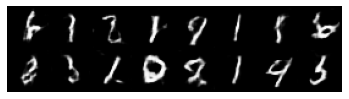

 22%|██▏       | 43/200 [1:13:32<4:33:48, 104.64s/it]

Epoch 44: DL=-0.6832, GL=-1.1816


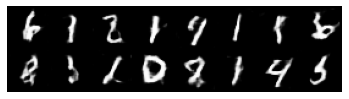

 22%|██▏       | 44/200 [1:15:16<4:31:53, 104.58s/it]

Epoch 45: DL=-0.6740, GL=-1.2026


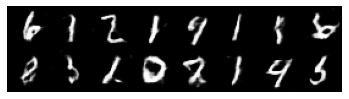

 22%|██▎       | 45/200 [1:17:01<4:30:14, 104.61s/it]

Epoch 46: DL=-0.6639, GL=-1.2503


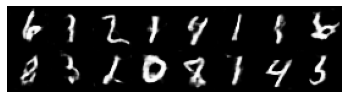

 23%|██▎       | 46/200 [1:18:45<4:28:28, 104.60s/it]

Epoch 47: DL=-0.6481, GL=-1.3281


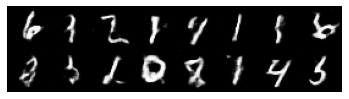

 24%|██▎       | 47/200 [1:20:30<4:26:43, 104.60s/it]

Epoch 48: DL=-0.6673, GL=-1.3370


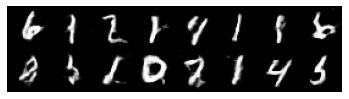

 24%|██▍       | 48/200 [1:22:14<4:24:56, 104.58s/it]

Epoch 49: DL=-0.6736, GL=-1.3838


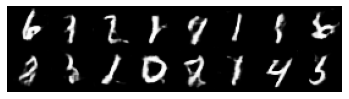

 24%|██▍       | 49/200 [1:23:59<4:23:02, 104.52s/it]

Epoch 50: DL=-0.6796, GL=-1.4151


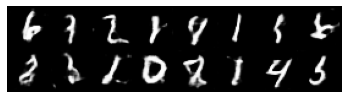

 25%|██▌       | 50/200 [1:25:43<4:21:22, 104.55s/it]

Epoch 51: DL=-0.6359, GL=-1.3729


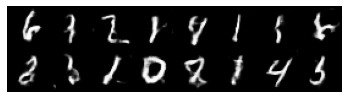

 26%|██▌       | 51/200 [1:27:28<4:19:31, 104.51s/it]

Epoch 52: DL=-0.6214, GL=-1.3308


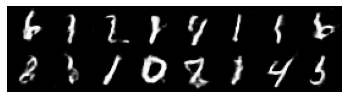

 26%|██▌       | 52/200 [1:29:13<4:17:56, 104.57s/it]

Epoch 53: DL=-0.6123, GL=-1.4441


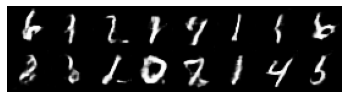

 26%|██▋       | 53/200 [1:30:57<4:16:04, 104.52s/it]

Epoch 54: DL=-0.6183, GL=-1.3968


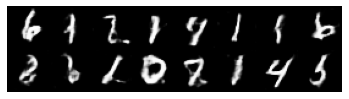

 27%|██▋       | 54/200 [1:32:42<4:14:23, 104.55s/it]

Epoch 55: DL=-0.6234, GL=-1.4502


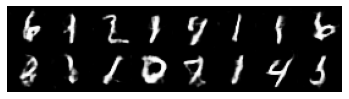

 28%|██▊       | 55/200 [1:34:01<3:54:34, 97.06s/it] 

Epoch 56: DL=-0.5850, GL=-1.4246


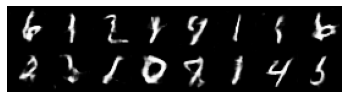

 28%|██▊       | 56/200 [1:35:20<3:39:37, 91.51s/it]

Epoch 57: DL=-0.6033, GL=-1.3732


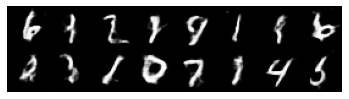

 28%|██▊       | 57/200 [1:36:38<3:28:41, 87.56s/it]

Epoch 58: DL=-0.5771, GL=-1.3011


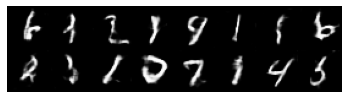

 29%|██▉       | 58/200 [1:37:57<3:20:45, 84.83s/it]

Epoch 59: DL=-0.6253, GL=-1.2457


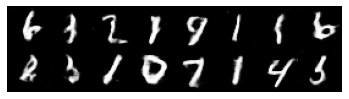

 30%|██▉       | 59/200 [1:39:15<3:14:49, 82.90s/it]

Epoch 60: DL=-0.6296, GL=-1.3268


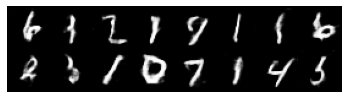

 30%|███       | 60/200 [1:40:33<3:10:20, 81.58s/it]

Epoch 61: DL=-0.5743, GL=-1.3303


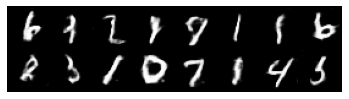

 30%|███       | 61/200 [1:41:52<3:06:50, 80.65s/it]

Epoch 62: DL=-0.5924, GL=-1.1925


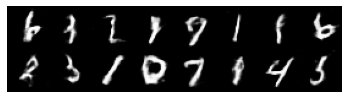

 31%|███       | 62/200 [1:43:10<3:04:03, 80.02s/it]

Epoch 63: DL=-0.6258, GL=-1.2536


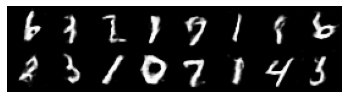

 32%|███▏      | 63/200 [1:44:29<3:01:26, 79.47s/it]

Epoch 64: DL=-0.5283, GL=-1.2492


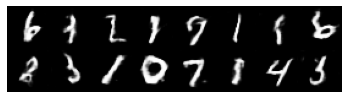

 32%|███▏      | 64/200 [1:45:47<2:59:31, 79.21s/it]

Epoch 65: DL=-0.5846, GL=-1.4077


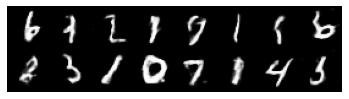

 32%|███▎      | 65/200 [1:47:05<2:57:30, 78.89s/it]

Epoch 66: DL=-0.5469, GL=-1.3959


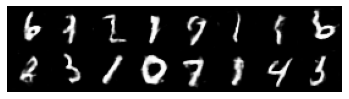

 33%|███▎      | 66/200 [1:48:24<2:55:57, 78.78s/it]

Epoch 67: DL=-0.5509, GL=-1.3090


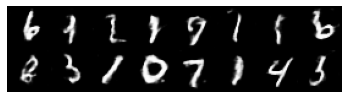

 34%|███▎      | 67/200 [1:49:42<2:54:23, 78.67s/it]

Epoch 68: DL=-0.5429, GL=-1.2062


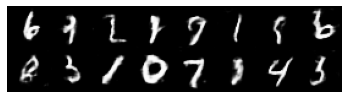

 34%|███▍      | 68/200 [1:51:01<2:52:56, 78.61s/it]

Epoch 69: DL=-0.5717, GL=-1.1843


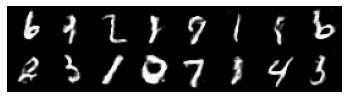

 34%|███▍      | 69/200 [1:52:19<2:51:20, 78.48s/it]

Epoch 70: DL=-0.5534, GL=-1.2282


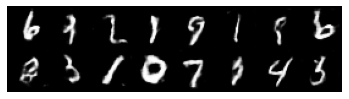

 35%|███▌      | 70/200 [1:53:37<2:50:02, 78.48s/it]

Epoch 71: DL=-0.5832, GL=-1.1347


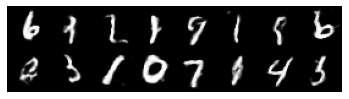

 36%|███▌      | 71/200 [1:54:56<2:48:44, 78.48s/it]

Epoch 72: DL=-0.5638, GL=-1.2156


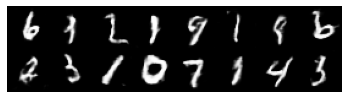

 36%|███▌      | 72/200 [1:56:14<2:47:18, 78.43s/it]

Epoch 73: DL=-0.5456, GL=-1.2618


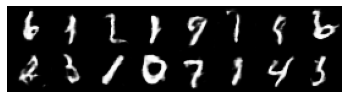

 36%|███▋      | 73/200 [1:57:33<2:45:57, 78.41s/it]

Epoch 74: DL=-0.5684, GL=-1.2282


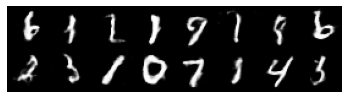

 37%|███▋      | 74/200 [1:58:51<2:44:46, 78.47s/it]

Epoch 75: DL=-0.5380, GL=-1.2290


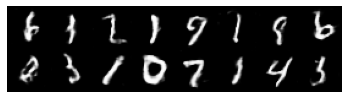

 38%|███▊      | 75/200 [2:00:10<2:43:24, 78.43s/it]

Epoch 76: DL=-0.5580, GL=-1.2346


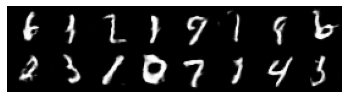

 38%|███▊      | 76/200 [2:01:28<2:41:59, 78.38s/it]

Epoch 77: DL=-0.5325, GL=-1.2583


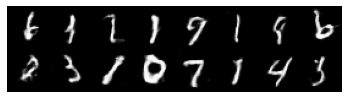

 38%|███▊      | 77/200 [2:02:46<2:40:48, 78.44s/it]

Epoch 78: DL=-0.5552, GL=-1.1805


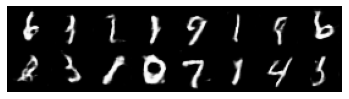

 39%|███▉      | 78/200 [2:04:05<2:39:27, 78.42s/it]

Epoch 79: DL=-0.5630, GL=-1.1596


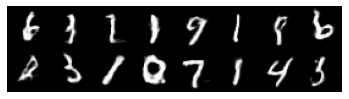

 40%|███▉      | 79/200 [2:05:23<2:38:11, 78.44s/it]

Epoch 80: DL=-0.5407, GL=-1.1760


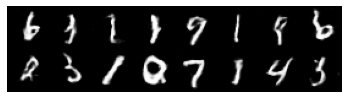

 40%|████      | 80/200 [2:06:42<2:36:58, 78.48s/it]

Epoch 81: DL=-0.5525, GL=-1.2246


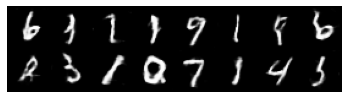

 40%|████      | 81/200 [2:08:00<2:35:39, 78.48s/it]

Epoch 82: DL=-0.5391, GL=-1.1928


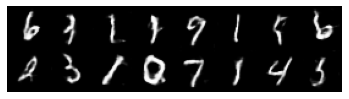

 41%|████      | 82/200 [2:09:19<2:34:17, 78.45s/it]

Epoch 83: DL=-0.5119, GL=-1.2086


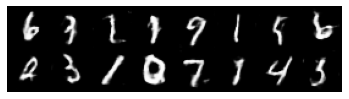

 42%|████▏     | 83/200 [2:10:37<2:33:02, 78.48s/it]

Epoch 84: DL=-0.4971, GL=-1.2323


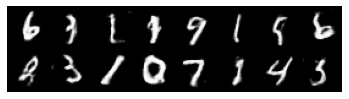

 42%|████▏     | 84/200 [2:11:56<2:31:37, 78.43s/it]

Epoch 85: DL=-0.5115, GL=-1.1286


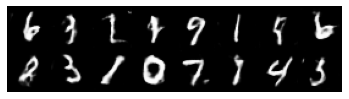

 42%|████▎     | 85/200 [2:13:14<2:30:18, 78.42s/it]

Epoch 86: DL=-0.5132, GL=-1.1388


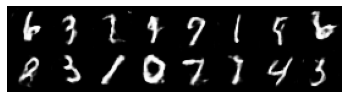

 43%|████▎     | 86/200 [2:14:32<2:29:02, 78.44s/it]

Epoch 87: DL=-0.4907, GL=-1.1677


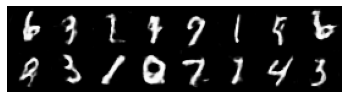

 44%|████▎     | 87/200 [2:15:51<2:27:42, 78.43s/it]

Epoch 88: DL=-0.5390, GL=-1.1437


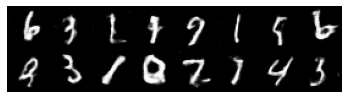

 44%|████▍     | 88/200 [2:17:09<2:26:19, 78.39s/it]

Epoch 89: DL=-0.5104, GL=-1.1187


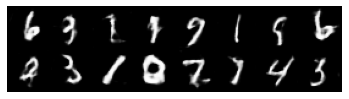

 44%|████▍     | 89/200 [2:18:28<2:25:05, 78.43s/it]

Epoch 90: DL=-0.5555, GL=-1.1300


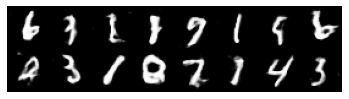

 45%|████▌     | 90/200 [2:19:46<2:23:40, 78.37s/it]

Epoch 91: DL=-0.4990, GL=-1.1541


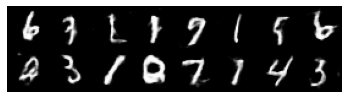

 46%|████▌     | 91/200 [2:21:04<2:22:16, 78.32s/it]

Epoch 92: DL=-0.5043, GL=-1.1376


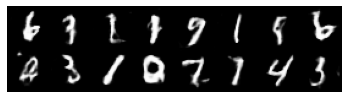

 46%|████▌     | 92/200 [2:22:23<2:21:01, 78.35s/it]

Epoch 93: DL=-0.4834, GL=-1.2004


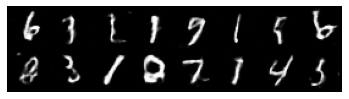

 46%|████▋     | 93/200 [2:23:41<2:19:45, 78.37s/it]

Epoch 94: DL=-0.5269, GL=-1.2291


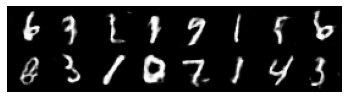

 47%|████▋     | 94/200 [2:24:59<2:18:29, 78.39s/it]

Epoch 95: DL=-0.5254, GL=-1.2442


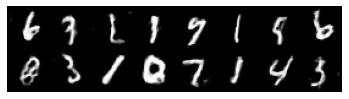

 48%|████▊     | 95/200 [2:26:18<2:17:07, 78.36s/it]

Epoch 96: DL=-0.5267, GL=-1.2571


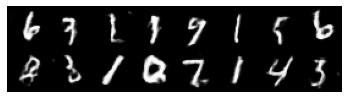

 48%|████▊     | 96/200 [2:27:36<2:15:51, 78.38s/it]

Epoch 97: DL=-0.4897, GL=-1.2061


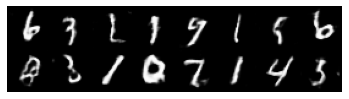

 48%|████▊     | 97/200 [2:28:54<2:14:30, 78.36s/it]

Epoch 98: DL=-0.4870, GL=-1.1900


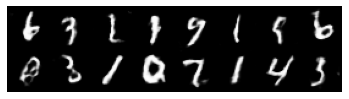

 49%|████▉     | 98/200 [2:30:13<2:13:17, 78.40s/it]

Epoch 99: DL=-0.4987, GL=-1.2307


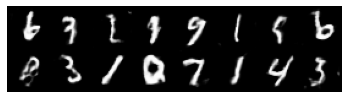

 50%|████▉     | 99/200 [2:31:31<2:12:02, 78.44s/it]

Epoch 100: DL=-0.5102, GL=-1.2693


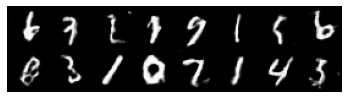

 50%|█████     | 100/200 [2:32:50<2:10:46, 78.46s/it]

Epoch 101: DL=-0.4629, GL=-1.1876


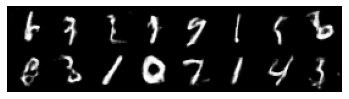

 50%|█████     | 101/200 [2:34:08<2:09:25, 78.44s/it]

Epoch 102: DL=-0.4255, GL=-1.1960


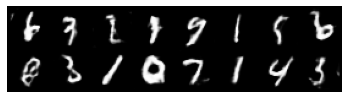

 51%|█████     | 102/200 [2:35:27<2:08:05, 78.42s/it]

Epoch 103: DL=-0.5131, GL=-1.2198


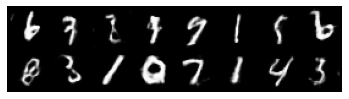

 52%|█████▏    | 103/200 [2:36:45<2:06:48, 78.44s/it]

Epoch 104: DL=-0.5025, GL=-1.2082


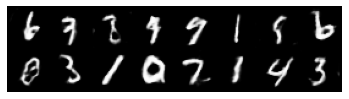

 52%|█████▏    | 104/200 [2:38:04<2:05:32, 78.46s/it]

Epoch 105: DL=-0.4859, GL=-1.1438


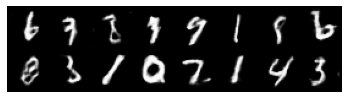

 52%|█████▎    | 105/200 [2:39:22<2:04:13, 78.46s/it]

Epoch 106: DL=-0.5175, GL=-1.1305


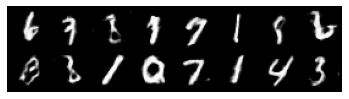

 53%|█████▎    | 106/200 [2:40:41<2:02:58, 78.49s/it]

Epoch 107: DL=-0.4571, GL=-1.0841


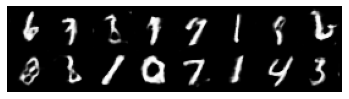

 54%|█████▎    | 107/200 [2:41:59<2:01:32, 78.41s/it]

Epoch 108: DL=-0.5007, GL=-1.0649


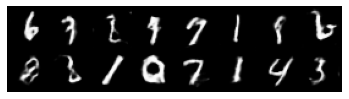

 54%|█████▍    | 108/200 [2:43:18<2:00:17, 78.45s/it]

Epoch 109: DL=-0.4969, GL=-1.1212


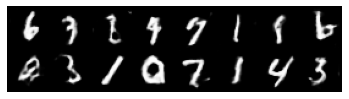

 55%|█████▍    | 109/200 [2:44:36<1:58:56, 78.43s/it]

Epoch 110: DL=-0.4929, GL=-1.1451


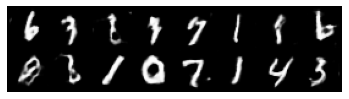

 55%|█████▌    | 110/200 [2:45:54<1:57:39, 78.44s/it]

Epoch 111: DL=-0.4642, GL=-1.0464


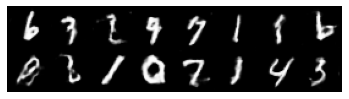

 56%|█████▌    | 111/200 [2:47:12<1:56:13, 78.35s/it]

Epoch 112: DL=-0.4675, GL=-1.0848


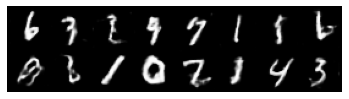

 56%|█████▌    | 112/200 [2:48:31<1:54:57, 78.38s/it]

Epoch 113: DL=-0.4965, GL=-1.0823


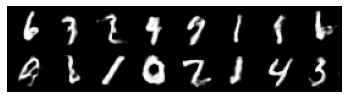

 56%|█████▋    | 113/200 [2:49:50<1:53:44, 78.45s/it]

Epoch 114: DL=-0.4515, GL=-1.1183


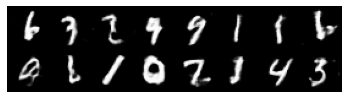

 57%|█████▋    | 114/200 [2:51:08<1:52:20, 78.38s/it]

Epoch 115: DL=-0.4981, GL=-1.1071


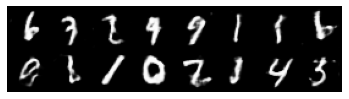

 57%|█████▊    | 115/200 [2:52:26<1:50:57, 78.32s/it]

Epoch 116: DL=-0.4669, GL=-1.0295


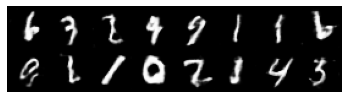

 58%|█████▊    | 116/200 [2:53:45<1:49:44, 78.39s/it]

Epoch 117: DL=-0.4727, GL=-1.0347


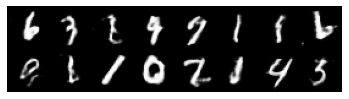

 58%|█████▊    | 117/200 [2:55:03<1:48:29, 78.43s/it]

Epoch 118: DL=-0.4700, GL=-0.9927


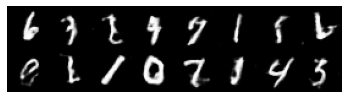

 59%|█████▉    | 118/200 [2:56:22<1:47:13, 78.46s/it]

Epoch 119: DL=-0.4654, GL=-1.0197


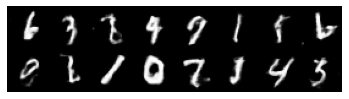

 60%|█████▉    | 119/200 [2:57:40<1:45:55, 78.46s/it]

Epoch 120: DL=-0.4189, GL=-1.0302


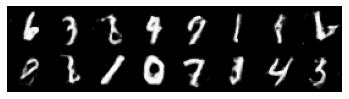

 60%|██████    | 120/200 [2:58:58<1:44:35, 78.44s/it]

Epoch 121: DL=-0.4205, GL=-1.0507


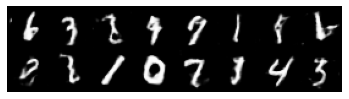

 60%|██████    | 121/200 [3:00:17<1:43:16, 78.44s/it]

Epoch 122: DL=-0.4899, GL=-0.9612


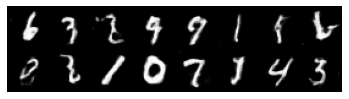

 61%|██████    | 122/200 [3:01:35<1:42:00, 78.47s/it]

Epoch 123: DL=-0.4532, GL=-0.9460


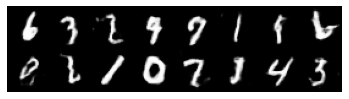

 62%|██████▏   | 123/200 [3:02:54<1:40:39, 78.43s/it]

Epoch 124: DL=-0.4632, GL=-0.9161


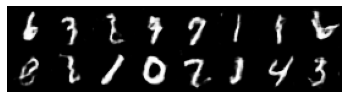

 62%|██████▏   | 124/200 [3:04:12<1:39:17, 78.38s/it]

Epoch 125: DL=-0.4579, GL=-0.8607


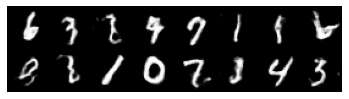

 62%|██████▎   | 125/200 [3:05:30<1:37:58, 78.38s/it]

Epoch 126: DL=-0.4509, GL=-0.9436


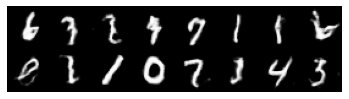

 63%|██████▎   | 126/200 [3:06:49<1:36:41, 78.39s/it]

Epoch 127: DL=-0.4471, GL=-0.9661


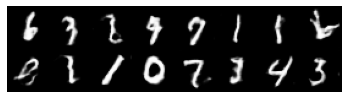

 64%|██████▎   | 127/200 [3:08:07<1:35:24, 78.41s/it]

Epoch 128: DL=-0.4478, GL=-1.0140


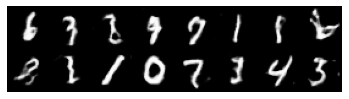

 64%|██████▍   | 128/200 [3:09:26<1:34:03, 78.39s/it]

Epoch 129: DL=-0.4503, GL=-1.0554


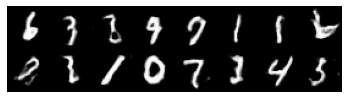

 64%|██████▍   | 129/200 [3:10:44<1:32:42, 78.35s/it]

Epoch 130: DL=-0.4535, GL=-1.0761


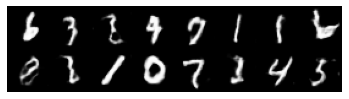

 65%|██████▌   | 130/200 [3:12:02<1:31:23, 78.34s/it]

Epoch 131: DL=-0.4893, GL=-1.1270


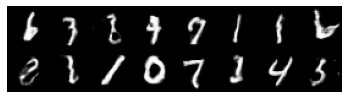

 66%|██████▌   | 131/200 [3:13:20<1:30:03, 78.31s/it]

Epoch 132: DL=-0.4803, GL=-1.0786


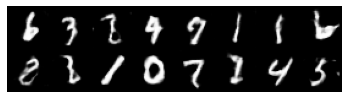

 66%|██████▌   | 132/200 [3:14:39<1:28:55, 78.46s/it]

Epoch 133: DL=-0.4391, GL=-1.0935


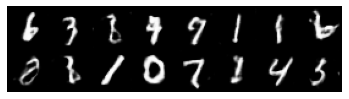

 66%|██████▋   | 133/200 [3:15:58<1:27:36, 78.45s/it]

Epoch 134: DL=-0.4586, GL=-1.0771


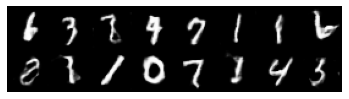

 67%|██████▋   | 134/200 [3:17:16<1:26:10, 78.34s/it]

Epoch 135: DL=-0.4196, GL=-1.0980


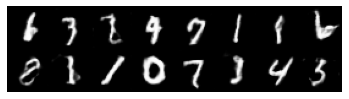

 68%|██████▊   | 135/200 [3:18:34<1:24:52, 78.34s/it]

Epoch 136: DL=-0.4443, GL=-1.1241


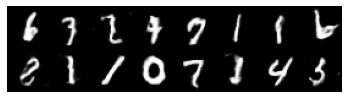

 68%|██████▊   | 136/200 [3:19:52<1:23:31, 78.30s/it]

Epoch 137: DL=-0.4236, GL=-1.0917


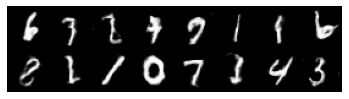

 68%|██████▊   | 137/200 [3:21:11<1:22:16, 78.36s/it]

Epoch 138: DL=-0.4309, GL=-0.9729


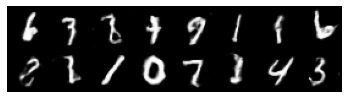

 69%|██████▉   | 138/200 [3:22:29<1:21:02, 78.43s/it]

Epoch 139: DL=-0.4807, GL=-1.0135


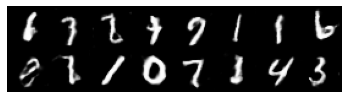

 70%|██████▉   | 139/200 [3:23:48<1:19:43, 78.42s/it]

Epoch 140: DL=-0.4685, GL=-1.0642


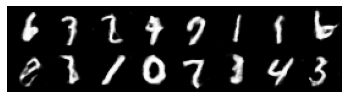

 70%|███████   | 140/200 [3:25:06<1:18:28, 78.47s/it]

Epoch 141: DL=-0.4373, GL=-1.1167


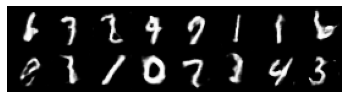

 70%|███████   | 141/200 [3:26:25<1:17:05, 78.41s/it]

Epoch 142: DL=-0.4662, GL=-1.1668


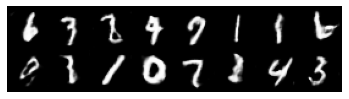

 71%|███████   | 142/200 [3:27:43<1:15:49, 78.45s/it]

Epoch 143: DL=-0.4523, GL=-1.1950


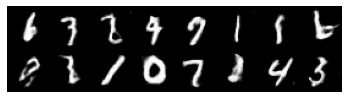

 72%|███████▏  | 143/200 [3:29:01<1:14:24, 78.33s/it]

Epoch 144: DL=-0.4288, GL=-1.1800


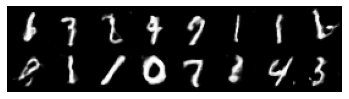

 72%|███████▏  | 144/200 [3:30:19<1:13:05, 78.30s/it]

Epoch 145: DL=-0.4391, GL=-1.0986


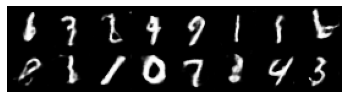

 72%|███████▎  | 145/200 [3:31:38<1:11:51, 78.40s/it]

Epoch 146: DL=-0.4063, GL=-1.1566


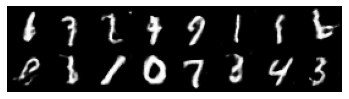

 73%|███████▎  | 146/200 [3:32:56<1:10:33, 78.40s/it]

Epoch 147: DL=-0.4328, GL=-1.1458


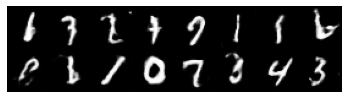

 74%|███████▎  | 147/200 [3:34:15<1:09:15, 78.41s/it]

Epoch 148: DL=-0.4261, GL=-1.1295


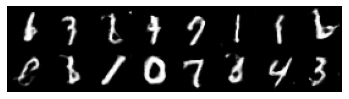

 74%|███████▍  | 148/200 [3:35:33<1:07:57, 78.41s/it]

Epoch 149: DL=-0.4431, GL=-1.1688


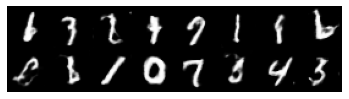

 74%|███████▍  | 149/200 [3:36:52<1:06:39, 78.41s/it]

Epoch 150: DL=-0.4602, GL=-1.1736


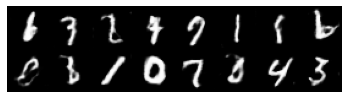

 75%|███████▌  | 150/200 [3:38:10<1:05:22, 78.44s/it]

Epoch 151: DL=-0.4757, GL=-1.2144


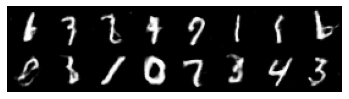

 76%|███████▌  | 151/200 [3:39:29<1:04:06, 78.50s/it]

Epoch 152: DL=-0.4160, GL=-1.2459


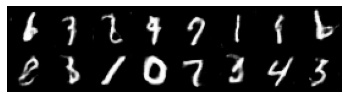

 76%|███████▌  | 152/200 [3:40:47<1:02:46, 78.47s/it]

Epoch 153: DL=-0.4523, GL=-1.1733


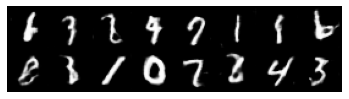

 76%|███████▋  | 153/200 [3:42:06<1:01:28, 78.47s/it]

Epoch 154: DL=-0.4289, GL=-1.1432


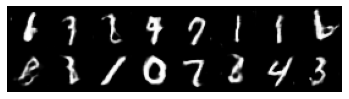

 77%|███████▋  | 154/200 [3:43:24<1:00:07, 78.43s/it]

Epoch 155: DL=-0.4404, GL=-1.1541


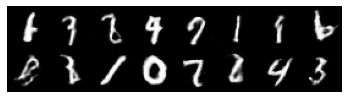

 78%|███████▊  | 155/200 [3:44:42<58:46, 78.38s/it]  

Epoch 156: DL=-0.4376, GL=-1.1684


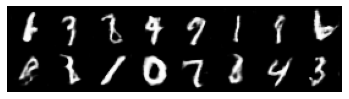

 78%|███████▊  | 156/200 [3:46:01<57:28, 78.38s/it]

Epoch 157: DL=-0.4781, GL=-1.1874


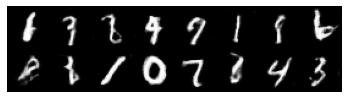

 78%|███████▊  | 157/200 [3:47:19<56:12, 78.42s/it]

Epoch 158: DL=-0.4187, GL=-1.1951


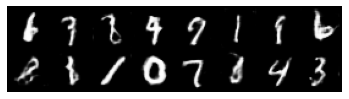

 79%|███████▉  | 158/200 [3:48:38<54:52, 78.40s/it]

Epoch 159: DL=-0.4166, GL=-1.2296


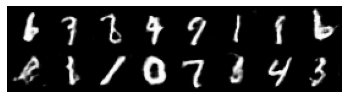

 80%|███████▉  | 159/200 [3:49:56<53:31, 78.32s/it]

Epoch 160: DL=-0.4285, GL=-1.2270


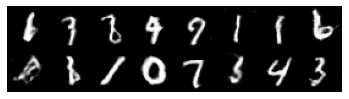

 80%|████████  | 160/200 [3:51:14<52:14, 78.36s/it]

Epoch 161: DL=-0.4084, GL=-1.2152


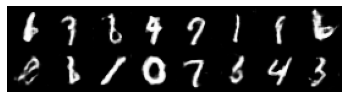

 80%|████████  | 161/200 [3:52:33<50:57, 78.41s/it]

Epoch 162: DL=-0.4742, GL=-1.2201


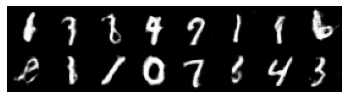

 81%|████████  | 162/200 [3:53:51<49:40, 78.43s/it]

Epoch 163: DL=-0.4126, GL=-1.1632


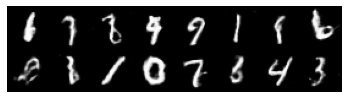

 82%|████████▏ | 163/200 [3:55:09<48:20, 78.38s/it]

Epoch 164: DL=-0.4145, GL=-1.1583


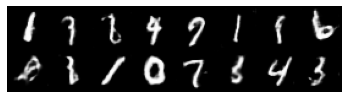

 82%|████████▏ | 164/200 [3:56:28<47:03, 78.43s/it]

Epoch 165: DL=-0.4220, GL=-1.0932


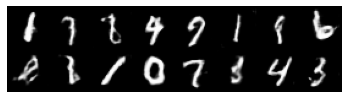

 82%|████████▎ | 165/200 [3:57:47<45:46, 78.47s/it]

Epoch 166: DL=-0.4111, GL=-1.1493


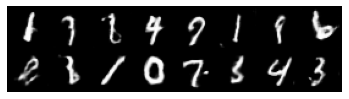

 83%|████████▎ | 166/200 [3:59:05<44:28, 78.49s/it]

Epoch 167: DL=-0.4252, GL=-1.2504


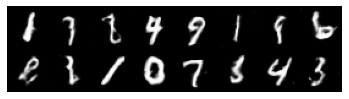

 84%|████████▎ | 167/200 [4:00:24<43:10, 78.51s/it]

Epoch 168: DL=-0.3927, GL=-1.2638


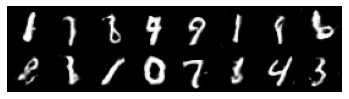

 84%|████████▍ | 168/200 [4:01:42<41:53, 78.53s/it]

Epoch 169: DL=-0.4313, GL=-1.2093


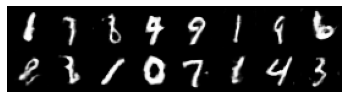

 84%|████████▍ | 169/200 [4:03:01<40:34, 78.52s/it]

Epoch 170: DL=-0.4324, GL=-1.1867


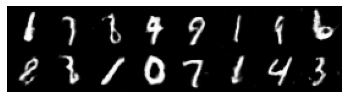

 85%|████████▌ | 170/200 [4:04:19<39:15, 78.51s/it]

Epoch 171: DL=-0.4437, GL=-1.1929


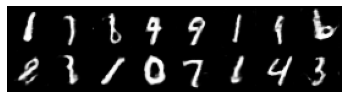

 86%|████████▌ | 171/200 [4:05:38<37:56, 78.50s/it]

Epoch 172: DL=-0.4619, GL=-1.1808


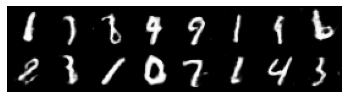

 86%|████████▌ | 172/200 [4:06:56<36:37, 78.47s/it]

Epoch 173: DL=-0.3947, GL=-1.1852


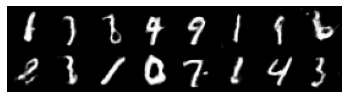

 86%|████████▋ | 173/200 [4:08:14<35:17, 78.42s/it]

Epoch 174: DL=-0.3927, GL=-1.1541


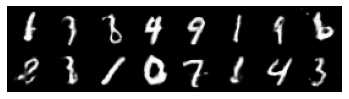

 87%|████████▋ | 174/200 [4:09:33<33:57, 78.38s/it]

Epoch 175: DL=-0.4115, GL=-1.0817


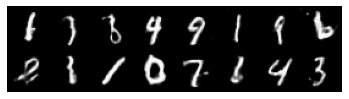

 88%|████████▊ | 175/200 [4:10:51<32:41, 78.47s/it]

Epoch 176: DL=-0.4393, GL=-1.1826


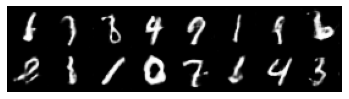

 88%|████████▊ | 176/200 [4:12:10<31:21, 78.41s/it]

Epoch 177: DL=-0.4306, GL=-1.2049


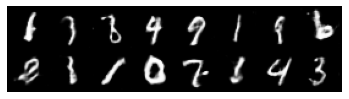

 88%|████████▊ | 177/200 [4:13:28<30:02, 78.39s/it]

Epoch 178: DL=-0.4161, GL=-1.1610


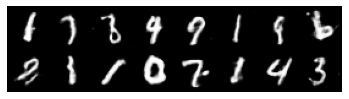

 89%|████████▉ | 178/200 [4:14:46<28:44, 78.40s/it]

Epoch 179: DL=-0.4225, GL=-1.1783


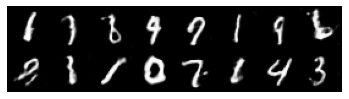

 90%|████████▉ | 179/200 [4:16:05<27:25, 78.37s/it]

Epoch 180: DL=-0.4597, GL=-1.2121


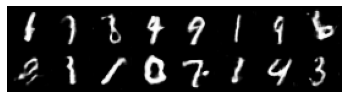

 90%|█████████ | 180/200 [4:17:23<26:08, 78.43s/it]

Epoch 181: DL=-0.3974, GL=-1.1336


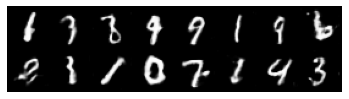

 90%|█████████ | 181/200 [4:18:42<24:49, 78.40s/it]

Epoch 182: DL=-0.4043, GL=-1.1079


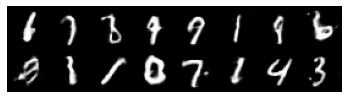

 91%|█████████ | 182/200 [4:20:00<23:30, 78.38s/it]

Epoch 183: DL=-0.4178, GL=-1.1110


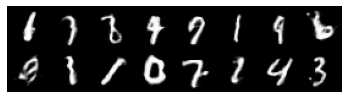

 92%|█████████▏| 183/200 [4:21:18<22:13, 78.43s/it]

Epoch 184: DL=-0.3827, GL=-1.1263


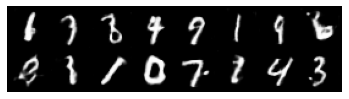

 92%|█████████▏| 184/200 [4:22:37<20:54, 78.43s/it]

Epoch 185: DL=-0.4106, GL=-1.1525


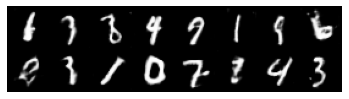

 92%|█████████▎| 185/200 [4:23:55<19:36, 78.42s/it]

Epoch 186: DL=-0.3902, GL=-1.0642


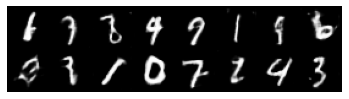

 93%|█████████▎| 186/200 [4:25:14<18:17, 78.42s/it]

Epoch 187: DL=-0.4407, GL=-1.0634


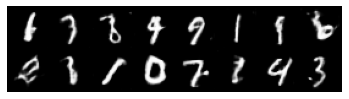

 94%|█████████▎| 187/200 [4:26:32<16:59, 78.45s/it]

Epoch 188: DL=-0.4041, GL=-1.1015


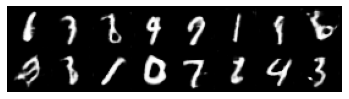

 94%|█████████▍| 188/200 [4:27:51<15:41, 78.45s/it]

Epoch 189: DL=-0.4190, GL=-1.0807


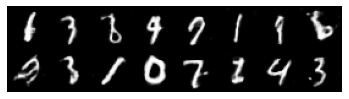

 94%|█████████▍| 189/200 [4:29:09<14:23, 78.46s/it]

Epoch 190: DL=-0.4147, GL=-1.0500


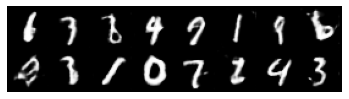

 95%|█████████▌| 190/200 [4:30:28<13:04, 78.43s/it]

Epoch 191: DL=-0.4301, GL=-1.0782


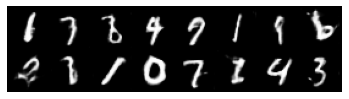

 96%|█████████▌| 191/200 [4:31:46<11:45, 78.40s/it]

Epoch 192: DL=-0.4243, GL=-1.0399


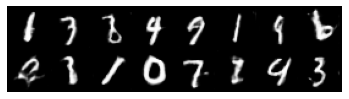

 96%|█████████▌| 192/200 [4:33:04<10:27, 78.44s/it]

Epoch 193: DL=-0.4143, GL=-0.9862


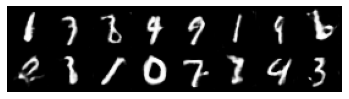

 96%|█████████▋| 193/200 [4:34:23<09:08, 78.40s/it]

Epoch 194: DL=-0.4410, GL=-0.9827


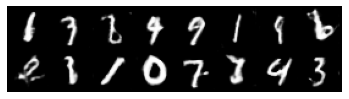

 97%|█████████▋| 194/200 [4:35:41<07:50, 78.38s/it]

Epoch 195: DL=-0.4223, GL=-0.9754


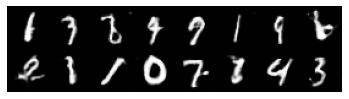

 98%|█████████▊| 195/200 [4:37:00<06:32, 78.41s/it]

Epoch 196: DL=-0.4329, GL=-0.9921


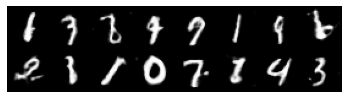

 98%|█████████▊| 196/200 [4:38:18<05:13, 78.45s/it]

Epoch 197: DL=-0.4198, GL=-1.0249


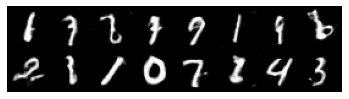

 98%|█████████▊| 197/200 [4:39:37<03:55, 78.49s/it]

Epoch 198: DL=-0.4105, GL=-1.0930


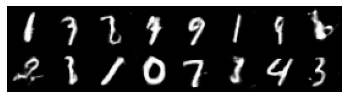

 99%|█████████▉| 198/200 [4:40:55<02:36, 78.45s/it]

Epoch 199: DL=-0.4079, GL=-1.0288


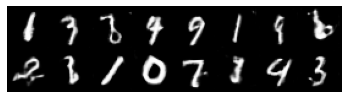

100%|█████████▉| 199/200 [4:42:13<01:18, 78.41s/it]

Epoch 200: DL=-0.4363, GL=-1.0650


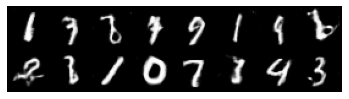

100%|██████████| 200/200 [4:43:32<00:00, 85.06s/it]


In [8]:
# ----------
#  Training
# ----------
fixed_noise = Tensor(np.random.normal(0, 1, (32, opt.latent_dim)))
batches_done = 0

# Loss history
hist_d_loss = []
hist_g_loss = []

for epoch in tqdm(range(opt.n_epochs)):
    # Losses 
    sum_d_loss = 0
    sum_g_loss = 0
    
    discriminator.train()
    generator.train()
    
    for i, (imgs, _) in enumerate(dataloader):
        
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        sum_d_loss += float(d_loss)
        
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)
            
            sum_g_loss += float(g_loss)

            g_loss.backward()
            optimizer_G.step()            
            
            if batches_done % opt.sample_interval == 0:
                save_image(fake_imgs.data[:25], os.path.join(opt.data_dir, "images_wgan_gp_modified/%d.png" % batches_done), nrow=5, normalize=True)

            batches_done += opt.n_critic
      
    epoch_d_loss = sum_d_loss/len(dataloader)
    epoch_g_loss = sum_g_loss/len(dataloader)
    hist_d_loss.append(epoch_d_loss)
    hist_g_loss.append(epoch_g_loss)
    print(f"Epoch {epoch+1}: DL={epoch_d_loss:.4f}, GL={epoch_g_loss:.4f}")
    
    generator.eval()
        
    with torch.no_grad():
        g_output = generator(fixed_noise)[:16,:,:]
        plt.imshow(transforms.ToPILImage()(make_grid(g_output, scale_each=True, normalize=True).cpu()))
        plt.axis('off')
        plt.show()

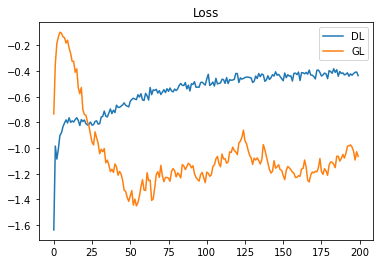

In [9]:
# Plot loss
plt.title("Loss")
plt.plot(hist_d_loss, label="DL")
plt.plot(hist_g_loss, label="GL")
plt.legend()
plt.show()